In [1]:
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
import os
import sys
from typing import Dict, Any
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(project_root)
print(project_root)
from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4
# from src.optimization.milp_schedulerv4_fixed import build_and_solve_schedule_v4
# FORCE plots to show in VSCode interactive + scripts
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

import matplotlib.pyplot as plt

/home/mak/Documents/Optimization/Project


In [2]:
# === File paths you must set ===
FIELDS = "../../data/processed/illinois_corn_fields_clean.csv"
WEATHER = "../../data/processed/noaa_il_weekly_clean.csv"
LABOR = "../../data/processed/labor_illinois_yearly_clean.csv"
MASTER = "../../data/processed/master_weekly_table.csv"

In [3]:
import pandas as pd

df = pd.read_csv("../../data/processed/labor_weekly_capacity_clean.csv")
df.head()
df.columns

Index(['year', 'week', 'labor_hours'], dtype='object')

# V5

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from typing import Optional

# =============================
# Import your v5 MILP model
# =============================
from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5


# =============================
# CONFIG
# =============================
N_SIM = 1000
TARGET_YEAR = 2017

FIELD_PATH  = "../../data/processed/illinois_corn_fields_clean.csv"
MASTER_BASE = "../../data/processed/master_weekly_table_2017_2024.csv"
OUTPUT_CSV  = "../../data/processed/monte_carlo_results_v5.csv"
TMP_FOLDER  = "../../data/processed/mc_v5/"

os.makedirs(TMP_FOLDER, exist_ok=True)

base_params = {
    "base_planter_capacity": 500.0,
    "base_harvester_capacity": 250.0,
    "labor_plant_per_acre": 0.2,
    "labor_harvest_per_acre": 0.3,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 5.0,
    "statewide_corn_acres": 12_000_000,
    "time_limit": 90,
}


# =============================
#  HELPER – Compute new capacity from rainfall
# =============================
def capacity_from_rain(prcp_week_in):
    if prcp_week_in < 0.5:
        return 1.0
    if prcp_week_in < 1.5:
        return 0.8
    if prcp_week_in < 3.0:
        return 0.5
    return 0.25


# =============================
# MAIN MONTE CARLO LOOP
# =============================
results = []

print(f"🔄 Running {N_SIM} Monte Carlo scenarios...\n")

for sim in tqdm(range(N_SIM)):

    # Load base master table
    wm = pd.read_csv(MASTER_BASE)
    wm_year = wm[wm["year"] == TARGET_YEAR].copy()

    # =====================================================
    # 1) LABOR SHOCK (normal ±20%)
    # =====================================================
    labor_noise = np.random.normal(1.0, 0.20, size=len(wm_year))
    wm_year["labor_hours"] = (wm_year["labor_hours"] * labor_noise).clip(lower=0)

    # =====================================================
    # 2) RAIN LOGNORMAL SHOCK + re-derive capacity
    # =====================================================
    if "prcp_week_in" in wm_year.columns:
        rain_noise = np.random.lognormal(mean=0, sigma=0.30, size=len(wm_year))
        wm_year["prcp_sim"] = wm_year["prcp_week_in"] * rain_noise
        wm_year["capacity_factor"] = wm_year["prcp_sim"].apply(capacity_from_rain)
    else:
        wm_year["capacity_factor"] = 1.0

    # =====================================================
    # 3) HARVEST WEATHER FACTOR — recompute using your function
    # =====================================================
    from src.optimization.milp_schedulerv5 import compute_harvest_weather_factor
    wm_year["harvest_weather_factor"] = wm_year.apply(
        compute_harvest_weather_factor, axis=1
    )

    # =====================================================
    # 4) RANDOM "WET WEEKS" (3–5 weeks)
    # =====================================================
    wet_weeks = np.random.choice(wm_year["week"], size=np.random.randint(3, 6), replace=False)
    wm_year.loc[wm_year["week"].isin(wet_weeks), "capacity_factor"] *= 0.7
    wm_year.loc[wm_year["week"].isin(wet_weeks), "harvest_weather_factor"] *= 0.75

    # =====================================================
    # 5) RANDOM MACHINE DOWNTIME (optional realism)
    # =====================================================
    if np.random.rand() < 0.25:  # 25% chance
        w_down = int(np.random.choice(wm_year["week"]))
        wm_year.loc[wm_year["week"] == w_down, "capacity_factor"] *= 0.5

    # =====================================================
    # 6) Write this simulation to file
    # =====================================================
    sim_path = f"{TMP_FOLDER}/weekly_sim_{sim}.csv"
    wm.loc[wm["year"] == TARGET_YEAR, wm_year.columns] = wm_year.values
    wm.to_csv(sim_path, index=False)

    # =====================================================
    # 7) RUN MILP (v5)
    # =====================================================
    try:
        df_res = build_and_solve_schedule_v5(
            fields_path=FIELD_PATH,
            weekly_master_path=sim_path,
            target_year=TARGET_YEAR,
            **base_params,
        )

        # If infeasible, the model returns {error: infeasible}
        if "error" in df_res.columns:
            results.append({
                "sim": sim,
                "makespan": None,
                "total_penalty": None,
                "late_harvests": None,
                "status": "INFEASIBLE"
            })
            continue

        # Extract metrics
        makespan = df_res["makespan"].max()
        total_penalty = df_res["early_penalty"].sum() + df_res["late_penalty"].sum()
        late_count = (df_res["status"] == "LATE").sum()

        results.append({
            "sim": sim,
            "makespan": makespan,
            "total_penalty": total_penalty,
            "late_harvests": late_count,
            "status": "OK",
        })

    except Exception as e:
        results.append({
            "sim": sim,
            "makespan": None,
            "total_penalty": None,
            "late_harvests": None,
            "status": "ERROR",
            "error": str(e)
        })


# =============================
# SAVE RESULTS
# =============================
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n🎉 Monte Carlo complete! Saved to: {OUTPUT_CSV}")
results_df.head()


# V6

In [ ]:
# =============================================================
# REALISTIC MONTE CARLO (v6) — With Strong Weather & Labor Shocks
# =============================================================

import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from src.optimization.milp_schedulerv5 import build_and_solve_schedule_v5, compute_harvest_weather_factor

# =============================================================
# CONFIG
# =============================================================
N_SIM        = 100
TARGET_YEAR  = 2017

FIELD_PATH   = "../../data/processed/illinois_corn_fields_clean.csv"
MASTER_BASE  = "../../data/processed/master_weekly_table_2017_2024.csv"
TMP_FOLDER   = "../../data/processed/mc_v6/"
OUTPUT_CSV   = "../../data/processed/monte_carlo_results_v6.csv"

os.makedirs(TMP_FOLDER, exist_ok=True)

# Slightly reduced machine capacity (more realistic)
base_params = {
    "base_planter_capacity": 700.0,   # ≈ 300–450 ac/day realistic
    "base_harvester_capacity": 450.0, # ≈ 100–180 ac/day realistic
    "labor_plant_per_acre": 0.25,
    "labor_harvest_per_acre": 0.35,
    "early_penalty_weight": 10.0,
    "late_penalty_weight": 10.0,
    "statewide_corn_acres": 12_000_000,
    "time_limit": 90,
}

# =============================================================
# HELPER FUNCTIONS
# =============================================================

def capacity_from_rain(prcp):
    """Realistic nonlinear rainfall impact."""
    if prcp < 0.5:
        return 1.0
    if prcp < 1.5:
        return 0.75
    if prcp < 3.0:
        return 0.40
    return 0.20  # very wet week → nearly impossible fieldwork


def generate_labor_AR1(n, rho=0.6, sigma=0.15):
    """AR(1) weekly labor shocks."""
    eps = np.random.normal(0, sigma, n)
    x = np.zeros(n)
    for t in range(1, n):
        x[t] = rho * x[t-1] + eps[t]
    return 1 + x  # centered at 1


def apply_soil_drying_delays(df, wet_weeks):
    """Wet weeks reduce capacity AND extend mud/sludge for 1–2 weeks."""
    for w in wet_weeks:
        df.loc[df["week"] == w, "capacity_factor"] *= 0.5
        df.loc[df["week"] == w, "harvest_weather_factor"] *= 0.5
        
        # soil drying lag: next 1–2 weeks still impaired
        lag = np.random.randint(1, 3)
        delayed_weeks = df["week"].between(w+1, w+lag)
        df.loc[delayed_weeks, "capacity_factor"] *= 0.7
        df.loc[delayed_weeks, "harvest_weather_factor"] *= 0.75

    return df


def apply_machine_breakdowns(df, p=0.20):
    """20% of years experience a 1–2 week breakdown."""
    if np.random.rand() < p:
        start = int(np.random.choice(df["week"]))
        duration = np.random.randint(1, 3)
        outage_weeks = df["week"].between(start, start + duration)
        df.loc[outage_weeks, "capacity_factor"] *= 0.3
    return df


# =============================================================
# MAIN MONTE CARLO LOOP
# =============================================================
results = []

print(f"🔄 Running {N_SIM} realistic Monte Carlo scenarios...\n")

for sim in tqdm(range(N_SIM)):

    # ---------------------------------------------
    # Load base weekly master
    # ---------------------------------------------
    wm = pd.read_csv(MASTER_BASE)
    wm_year = wm[wm["year"] == TARGET_YEAR].copy()
    n_weeks = len(wm_year)

    # ---------------------------------------------
    # 1) LABOR SHOCK (AR(1) correlated)
    # ---------------------------------------------
    labor_mult = generate_labor_AR1(n_weeks, rho=0.7, sigma=0.20)
    wm_year["labor_hours"] *= labor_mult.clip(0.3, 1.5)  # realistic bounds

    # ---------------------------------------------
    # 2) RAINFALL SHOCK — lognormal, fat tails
    # ---------------------------------------------
    rain_mult = np.random.lognormal(mean=0, sigma=0.40, size=n_weeks)
    wm_year["prcp_sim"] = wm_year["prcp_week_in"] * rain_mult

    # Recompute capacity
    wm_year["capacity_factor"] = wm_year["prcp_sim"].apply(capacity_from_rain)

    # ---------------------------------------------
    # 3) HARVEST WEATHER FACTOR
    # ---------------------------------------------
    wm_year["harvest_weather_factor"] = wm_year.apply(
        compute_harvest_weather_factor, axis=1
    )

    # ---------------------------------------------
    # 4) STORM CLUSTERS (persistent wet systems)
    # ---------------------------------------------
    n_clusters = np.random.randint(1, 3)  # 1–2 storm systems per year
    wet_weeks = []

    for _ in range(n_clusters):
        start = int(np.random.choice(wm_year["week"]))
        duration = np.random.randint(1, 4)  # 1–3 week storm
        storm_weeks = list(range(start, start + duration))
        wet_weeks.extend(storm_weeks)

    wet_weeks = list(set(wet_weeks))
    wm_year = apply_soil_drying_delays(wm_year, wet_weeks)

    # ---------------------------------------------
    # 5) MACHINE BREAKDOWNS (1–2 week outage)
    # ---------------------------------------------
    wm_year = apply_machine_breakdowns(wm_year, p=0.20)

    # ---------------------------------------------
    # 6) RANDOM PLANTING START SHIFT (cold/wet spring)
    # ---------------------------------------------
    shift = np.random.choice([0, 0, 0, 1, 2, 3])  # most years no delay; some delayed
    wm_year["plant_start_week"] += shift
    wm_year["plant_end_week"] += shift

    # ---------------------------------------------
    # 7) Save sim file
    # ---------------------------------------------
    sim_path = f"{TMP_FOLDER}/weekly_sim_{sim}.csv"
    wm.loc[wm["year"] == TARGET_YEAR, wm_year.columns] = wm_year.values
    wm.to_csv(sim_path, index=False)

    # ---------------------------------------------
    # 8) Solve MILP (v5)
    # ---------------------------------------------
    try:
        df_res = build_and_solve_schedule_v5(
            fields_path=FIELD_PATH,
            weekly_master_path=sim_path,
            target_year=TARGET_YEAR,
            **base_params
        )

        if "error" in df_res.columns:
            results.append({
                "sim": sim,
                "makespan": None,
                "total_penalty": None,
                "late_harvests": None,
                "status": "INFEASIBLE"
            })
            continue

        makespan = df_res["makespan"].max()
        total_penalty = df_res["early_penalty"].sum() + df_res["late_penalty"].sum()
        late_count = (df_res["status"] == "LATE").sum()

        results.append({
            "sim": sim,
            "makespan": makespan,
            "total_penalty": total_penalty,
            "late_harvests": late_count,
            "status": "OK"
        })

    except Exception as e:
        results.append({
            "sim": sim,
            "makespan": None,
            "total_penalty": None,
            "late_harvests": None,
            "status": "ERROR",
            "error": str(e)
        })

# =============================================================
# SAVE OUTPUT
# =============================================================
results_df = pd.DataFrame(results)
results_df.to_csv(OUTPUT_CSV, index=False)

print(f"\n🎉 Realistic Monte Carlo complete! Saved to {OUTPUT_CSV}")
results_df.head()


Valid simulations: 77


,count,mean,std,min,25%,50%,75%,max,variance
makespan,77.0,39.571428,1.105353,38.999997,39.0,39.0,40.0,44.0,1.221805
total_penalty,77.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
late_harvests,77.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


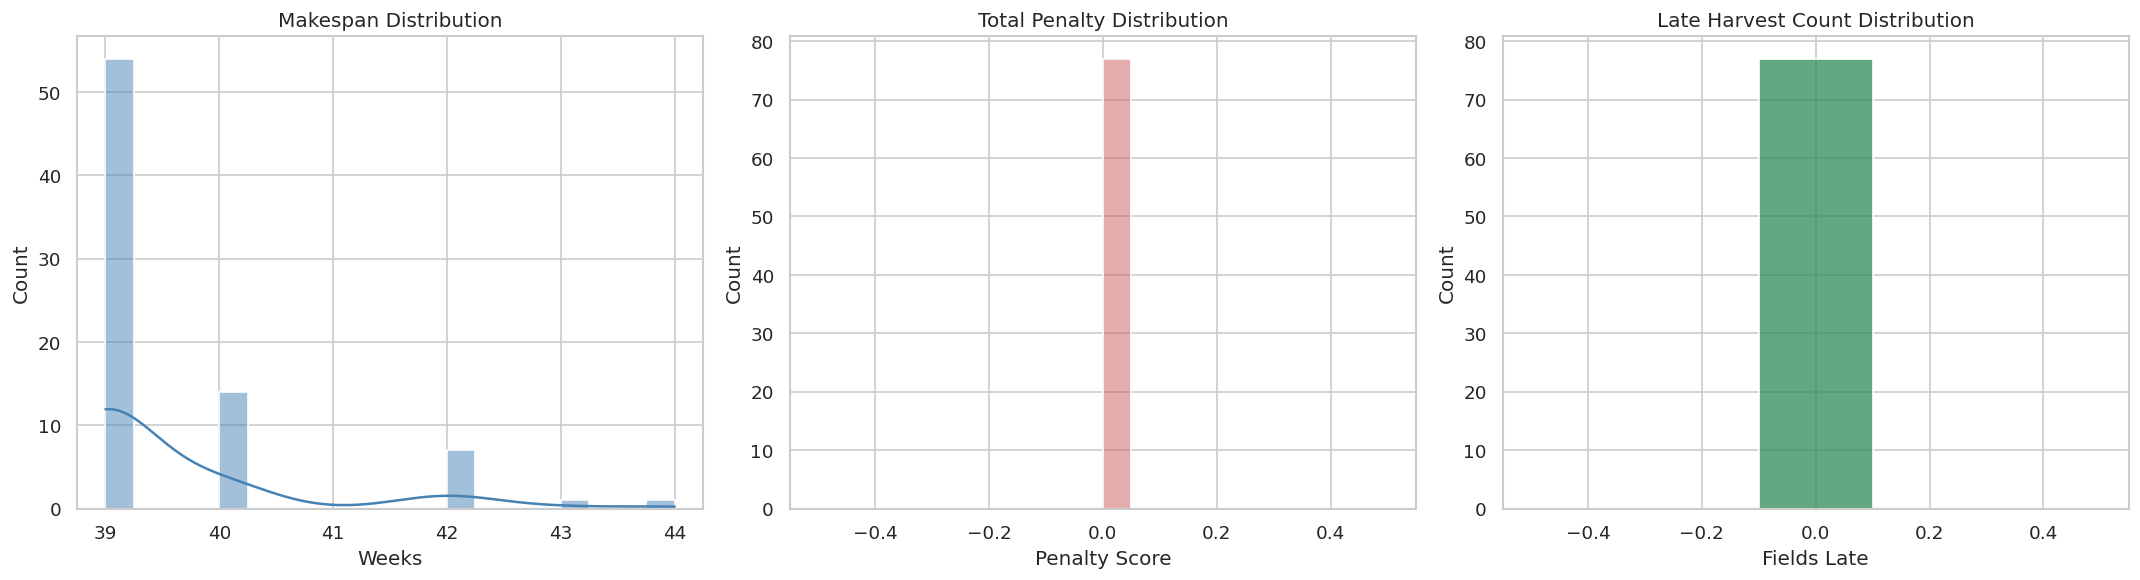

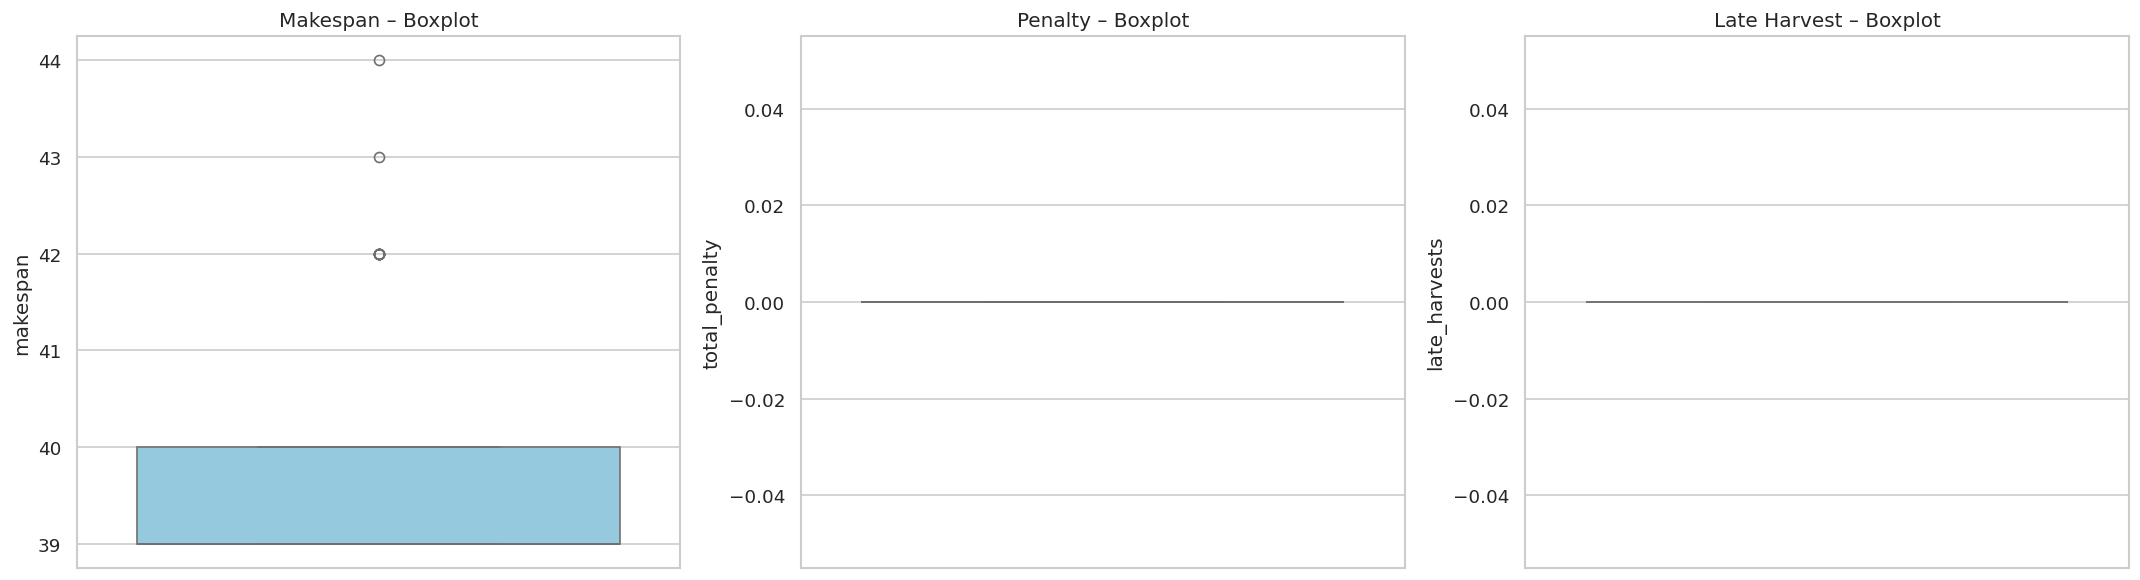

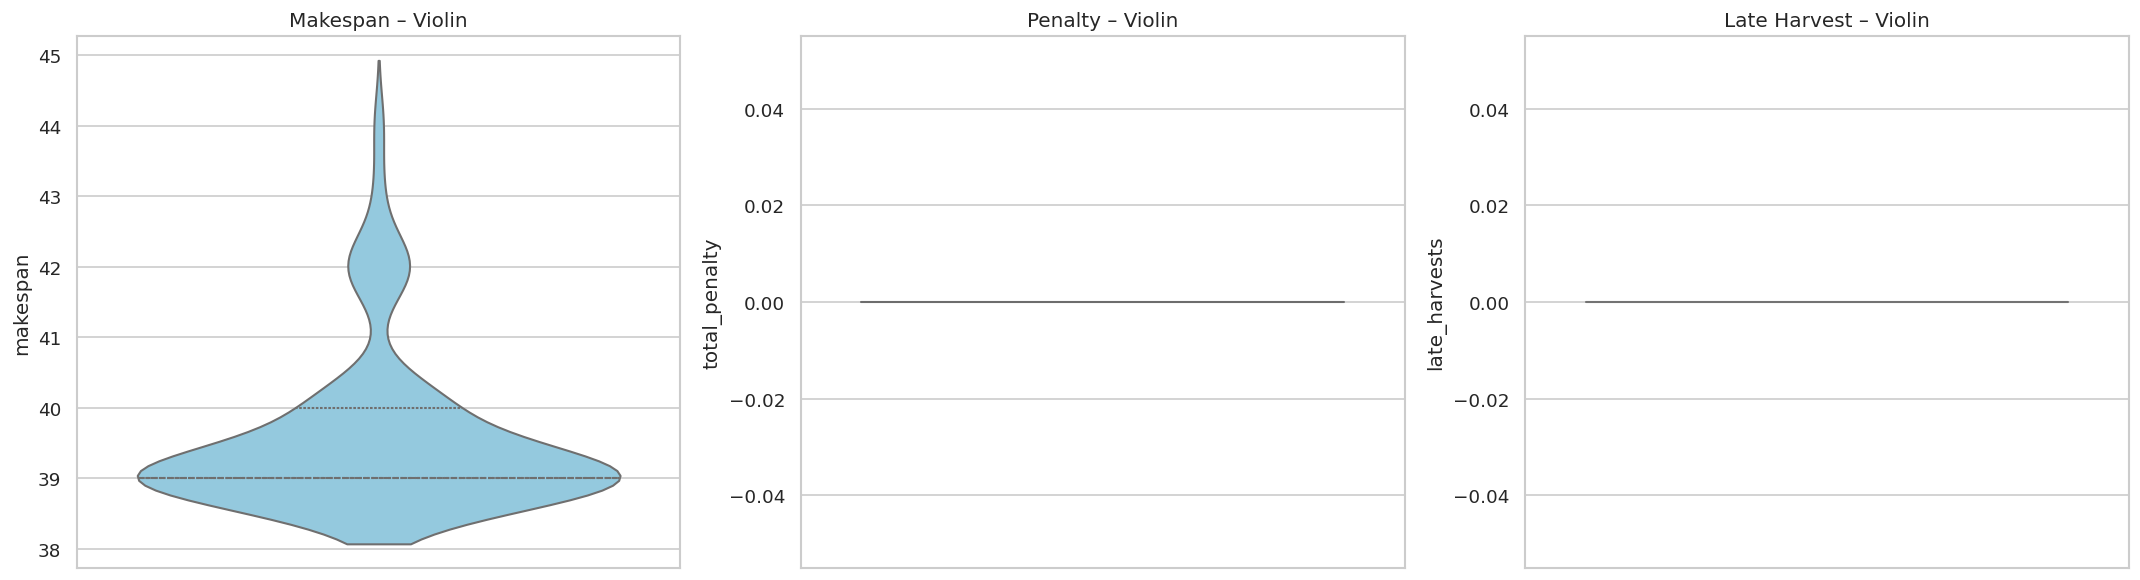

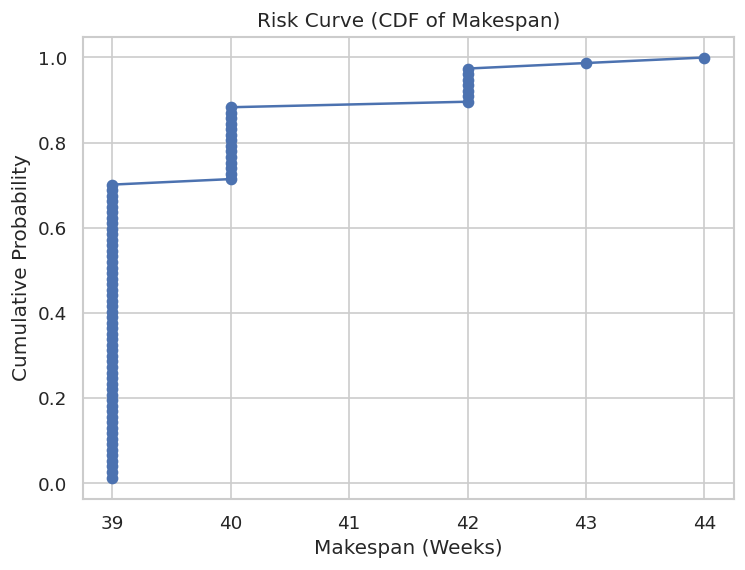

50th percentile = 39.00 weeks
75th percentile = 40.00 weeks
90th percentile = 42.00 weeks
95th percentile = 42.00 weeks


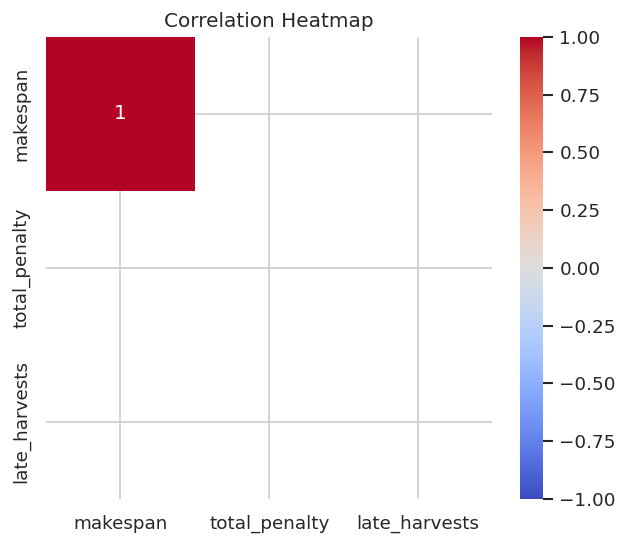

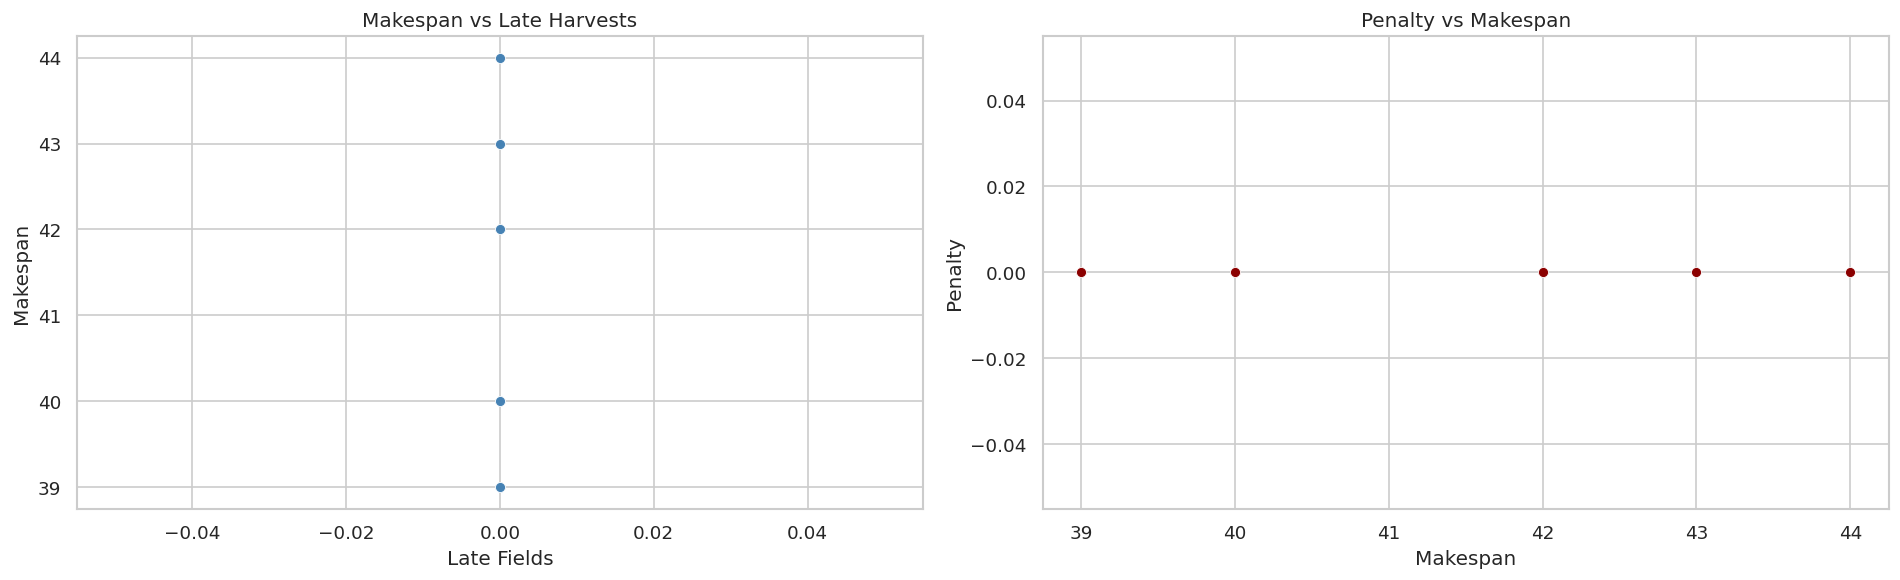

In [5]:
# =========================================================
# UPDATED MONTE CARLO VISUALIZATION SCRIPT (FOR MILP v5)
# =========================================================
# ============================================
#   MONTE CARLO VISUALIZATION – CLEAN VERSION
# ============================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6,4)

# -------------------------
# Load results
# -------------------------
df = pd.read_csv("../../data/processed/monte_carlo_results_v6.csv")

df_ok = df[df["status"] == "OK"].copy()
df_ok = df_ok[["makespan", "total_penalty", "late_harvests"]].dropna()

print("Valid simulations:", len(df_ok))

# -------------------------
# Summary stats
# -------------------------
summary = df_ok.describe().T
summary["variance"] = summary["std"]**2
display(summary)

# -------------------------
# Histograms
# -------------------------

fig, ax = plt.subplots(1, 3, figsize=(18,5))

sns.histplot(df_ok["makespan"], kde=True, bins=20, ax=ax[0], color="steelblue")
ax[0].set_title("Makespan Distribution")
ax[0].set_xlabel("Weeks")

sns.histplot(df_ok["total_penalty"], kde=True, bins=20, ax=ax[1], color="indianred")
ax[1].set_title("Total Penalty Distribution")
ax[1].set_xlabel("Penalty Score")

sns.histplot(df_ok["late_harvests"], kde=False, bins=5, ax=ax[2], color="seagreen")
ax[2].set_title("Late Harvest Count Distribution")
ax[2].set_xlabel("Fields Late")

plt.tight_layout()
plt.show()


# -------------------------
# Boxplots
# -------------------------
fig, ax = plt.subplots(1, 3, figsize=(18,5))

sns.boxplot(y=df_ok["makespan"], ax=ax[0], color="skyblue")
ax[0].set_title("Makespan – Boxplot")

sns.boxplot(y=df_ok["total_penalty"], ax=ax[1], color="salmon")
ax[1].set_title("Penalty – Boxplot")

sns.boxplot(y=df_ok["late_harvests"], ax=ax[2], color="lightgreen")
ax[2].set_title("Late Harvest – Boxplot")

plt.tight_layout()
plt.show()


# -------------------------
# Violin plots
# -------------------------
fig, ax = plt.subplots(1, 3, figsize=(18,5))

sns.violinplot(y=df_ok["makespan"], ax=ax[0], color="skyblue", inner="quartile")
ax[0].set_title("Makespan – Violin")

sns.violinplot(y=df_ok["total_penalty"], ax=ax[1], color="salmon", inner="quartile")
ax[1].set_title("Penalty – Violin")

sns.violinplot(y=df_ok["late_harvests"], ax=ax[2], color="lightgreen", inner="quartile")
ax[2].set_title("Late Harvest – Violin")

plt.tight_layout()
plt.show()


# -------------------------
# CDF (Risk Curve)
# -------------------------
sorted_m = np.sort(df_ok["makespan"])
cdf = np.arange(1, len(sorted_m)+1) / len(sorted_m)

plt.figure(figsize=(7,5))
plt.plot(sorted_m, cdf, marker="o")
plt.title("Risk Curve (CDF of Makespan)")
plt.xlabel("Makespan (Weeks)")
plt.ylabel("Cumulative Probability")
plt.grid(True)
plt.show()

percentiles = [50, 75, 90, 95]
for p in percentiles:
    print(f"{p}th percentile = {np.percentile(sorted_m, p):.2f} weeks")


# -------------------------
# Correlation Heatmap
# -------------------------
plt.figure(figsize=(6,5))
sns.heatmap(df_ok.corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()


# -------------------------
# Scatterplots
# -------------------------
fig, ax = plt.subplots(1, 2, figsize=(16,5))

sns.scatterplot(
    x=df_ok["late_harvests"],
    y=df_ok["makespan"],
    ax=ax[0], color="steelblue"
)
ax[0].set_title("Makespan vs Late Harvests")
ax[0].set_xlabel("Late Fields")
ax[0].set_ylabel("Makespan")

sns.scatterplot(
    x=df_ok["makespan"],
    y=df_ok["total_penalty"],
    ax=ax[1], color="darkred"
)
ax[1].set_title("Penalty vs Makespan")
ax[1].set_xlabel("Makespan")
ax[1].set_ylabel("Penalty")

plt.tight_layout()
plt.show()


📌 Total simulations: 1000
✔ Feasible: 477
❌ Infeasible or error: 523


================ SUMMARY STATISTICS ================



,count,mean,std,min,25%,50%,75%,max,variance
makespan,477.0,43.471698,0.684259,41.999998,43.0,43.0,44.0,52.000000,0.46821
total_penalty,477.0,12.770815,278.918804,0.000000,0.0,0.0,0.0,6091.678637,77795.69940
late_harvests,477.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000


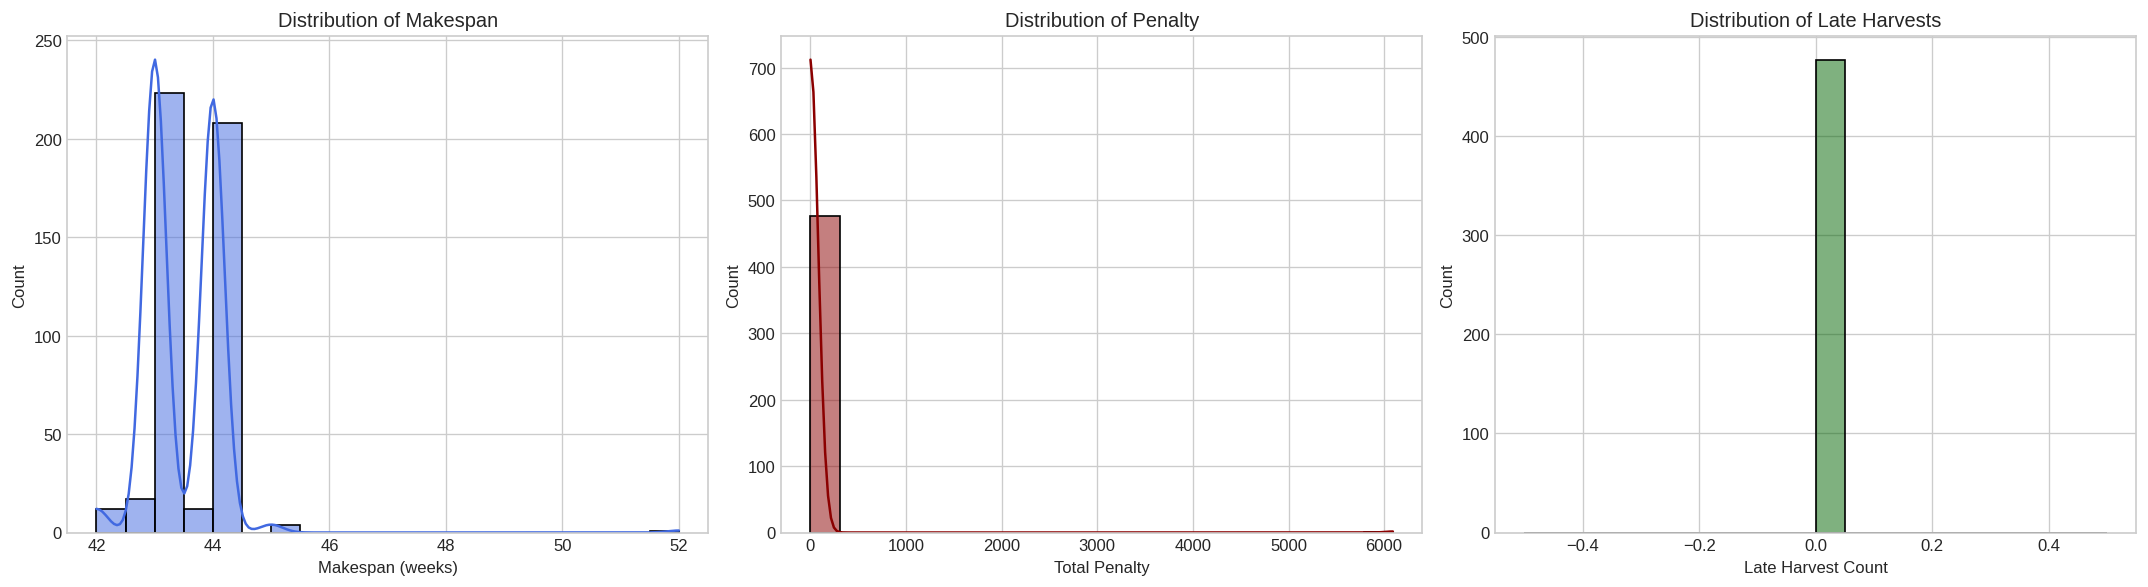

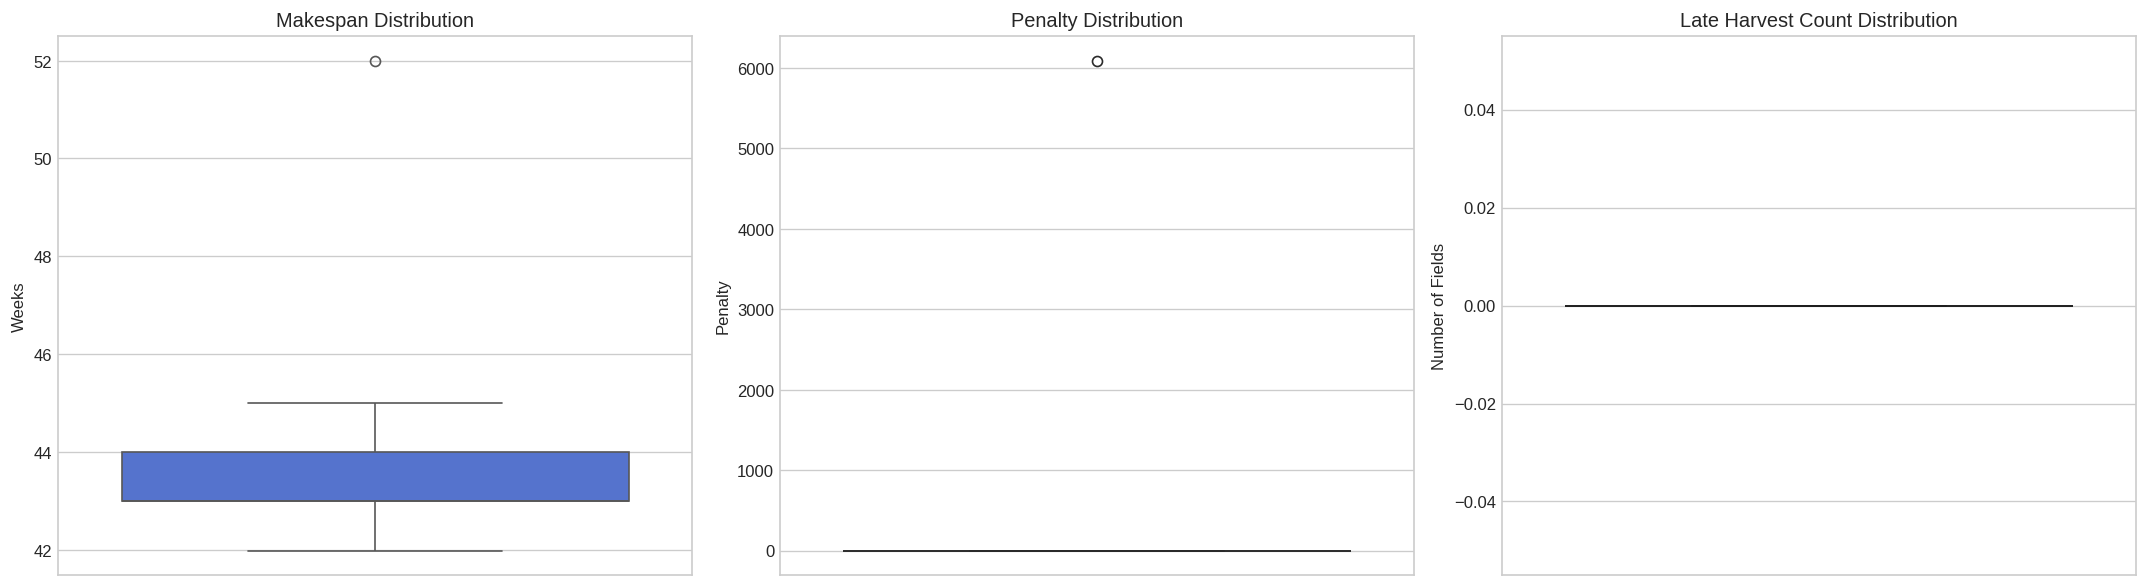

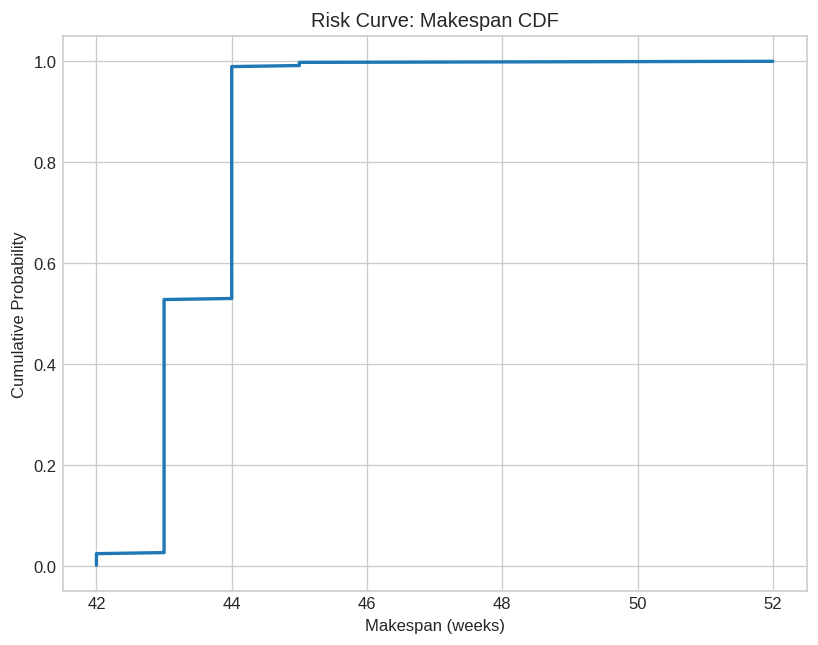


=============== RISK LEVELS (MAKESPAN) ===============
50th percentile: 43.00 weeks
75th percentile: 44.00 weeks
90th percentile: 44.00 weeks
95th percentile: 44.00 weeks
99th percentile: 44.24 weeks


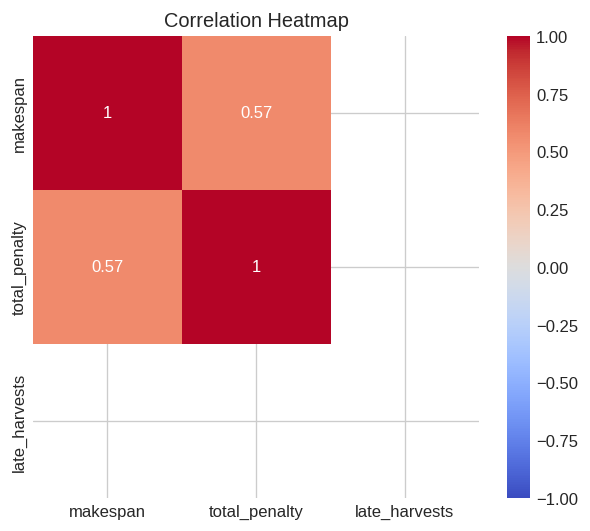

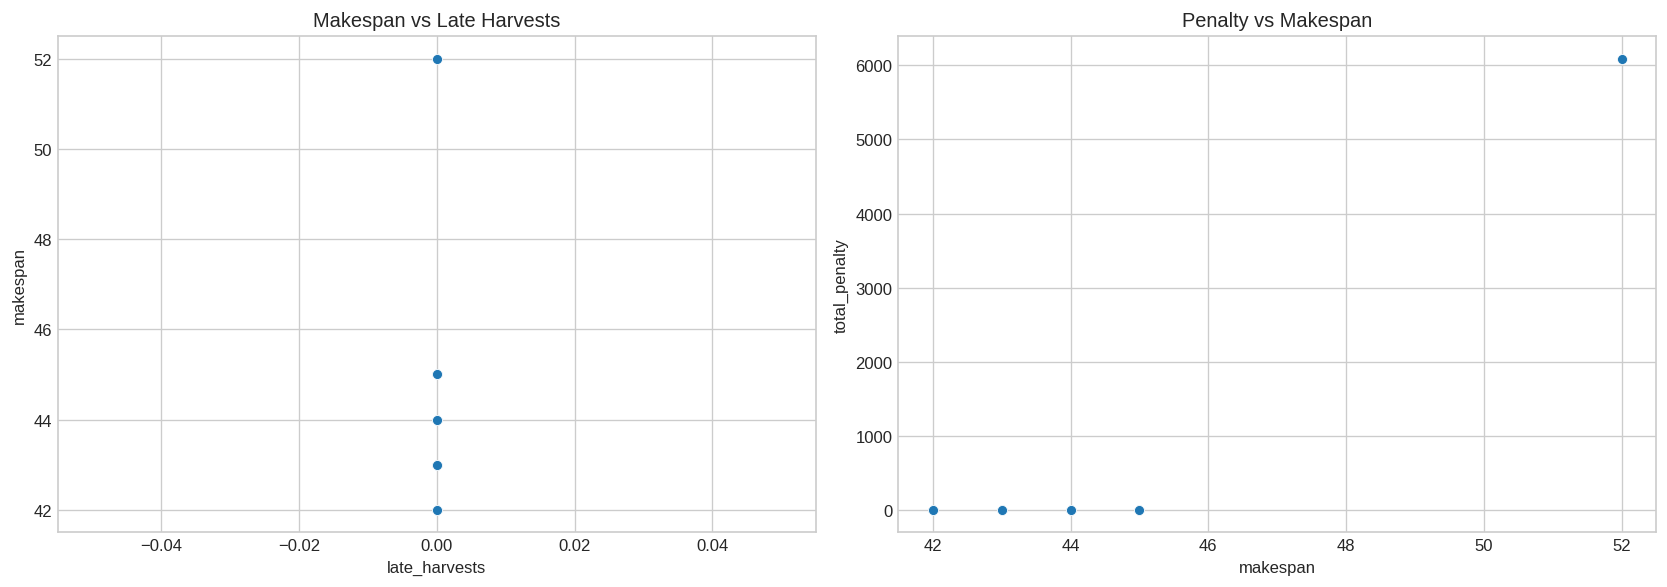


=============== BEST 5 SCENARIOS ===============


,sim,makespan,total_penalty,late_harvests,status,error
293,293,41.999998,0.0,0.0,OK,NaN
736,736,41.999999,0.0,0.0,OK,NaN
965,965,42.000000,0.0,0.0,OK,NaN
308,308,42.000000,0.0,0.0,OK,NaN
344,344,42.000000,0.0,0.0,OK,NaN



=============== WORST 5 SCENARIOS ===============


,sim,makespan,total_penalty,late_harvests,status,error
934,934,45.0,0.000000,0.0,OK,NaN
284,284,45.0,0.000000,0.0,OK,NaN
89,89,45.0,0.000000,0.0,OK,NaN
447,447,45.0,0.000000,0.0,OK,NaN
915,915,52.0,6091.678637,0.0,OK,NaN



=============== STRESS-TEST SUMMARY ===============

- Average makespan: 43.47 weeks
- Worst-case makespan: 52.00 weeks
- Probability makespan > 40 weeks: 100.0%
- Correlation (late_harvests → makespan): nan
- Penalties triggered — indicates early/late behavior or weather-driven delay.



/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/mak/Documents/Optimization/Project/.venv/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [6]:
# =========================================================
# MONTE CARLO ANALYSIS REPORT — FOR MILP v5 SIMULATION
# =========================================================

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")

RESULTS_PATH = "../../data/processed/monte_carlo_results_v5.csv"

# =========================================================
# 0) LOAD + FILTER RESULTS
# =========================================================
df = pd.read_csv(RESULTS_PATH)

df_ok = df[df["status"] == "OK"].copy()
df_bad = df[df["status"] != "OK"]

print(f"📌 Total simulations: {len(df)}")
print(f"✔ Feasible: {len(df_ok)}")
print(f"❌ Infeasible or error: {len(df_bad)}\n")

# =========================================================
# 1) SUMMARY STATISTICS
# =========================================================

summary = df_ok[["makespan", "total_penalty", "late_harvests"]].describe().T
summary["variance"] = summary["std"] ** 2

print("\n================ SUMMARY STATISTICS ================\n")
display(summary)

# =========================================================
# 2) DISTRIBUTIONS
# =========================================================

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_ok["makespan"], kde=True, bins=20, color="royalblue", ax=axs[0])
axs[0].set_title("Distribution of Makespan")
axs[0].set_xlabel("Makespan (weeks)")

sns.histplot(df_ok["total_penalty"], kde=True, bins=20, color="darkred", ax=axs[1])
axs[1].set_title("Distribution of Penalty")
axs[1].set_xlabel("Total Penalty")

sns.histplot(df_ok["late_harvests"], kde=True, bins=20, color="darkgreen", ax=axs[2])
axs[2].set_title("Distribution of Late Harvests")
axs[2].set_xlabel("Late Harvest Count")

plt.tight_layout()
plt.show()

# =========================================================
# 3) BOXPLOTS
# =========================================================

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=df_ok["makespan"], color="royalblue", ax=axs[0])
axs[0].set_title("Makespan Distribution")
axs[0].set_ylabel("Weeks")

sns.boxplot(y=df_ok["total_penalty"], color="darkred", ax=axs[1])
axs[1].set_title("Penalty Distribution")
axs[1].set_ylabel("Penalty")

sns.boxplot(y=df_ok["late_harvests"], color="darkgreen", ax=axs[2])
axs[2].set_title("Late Harvest Count Distribution")
axs[2].set_ylabel("Number of Fields")

plt.tight_layout()
plt.show()

# =========================================================
# 4) RISK CURVE (CDF OF MAKESPAN)
# =========================================================

sorted_makespan = np.sort(df_ok["makespan"])
cdf = np.arange(1, len(sorted_makespan) + 1) / len(sorted_makespan)

plt.figure(figsize=(8, 6))
plt.plot(sorted_makespan, cdf, linewidth=2)
plt.xlabel("Makespan (weeks)")
plt.ylabel("Cumulative Probability")
plt.title("Risk Curve: Makespan CDF")
plt.grid(True)
plt.show()

# Key percentiles
percentiles = [50, 75, 90, 95, 99]
risk_stats = {p: np.percentile(df_ok["makespan"], p) for p in percentiles}

print("\n=============== RISK LEVELS (MAKESPAN) ===============")
for p, val in risk_stats.items():
    print(f"{p}th percentile: {val:.2f} weeks")

# =========================================================
# 5) CORRELATION ANALYSIS
# =========================================================

plt.figure(figsize=(6, 5))
sns.heatmap(df_ok[["makespan", "total_penalty", "late_harvests"]].corr(),
            annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

# Scatter plots
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=df_ok, x="late_harvests", y="makespan", ax=axs[0])
axs[0].set_title("Makespan vs Late Harvests")

sns.scatterplot(data=df_ok, x="makespan", y="total_penalty", ax=axs[1])
axs[1].set_title("Penalty vs Makespan")

plt.tight_layout()
plt.show()

# =========================================================
# 6) BEST & WORST CASES
# =========================================================

best_5 = df_ok.sort_values("makespan").head(5)
worst_5 = df_ok.sort_values("makespan").tail(5)

print("\n=============== BEST 5 SCENARIOS ===============")
display(best_5)

print("\n=============== WORST 5 SCENARIOS ===============")
display(worst_5)

# =========================================================
# 7) STRESS TEST INTERPRETATION
# =========================================================

print("\n=============== STRESS-TEST SUMMARY ===============\n")
print(f"- Average makespan: {df_ok['makespan'].mean():.2f} weeks")
print(f"- Worst-case makespan: {df_ok['makespan'].max():.2f} weeks")
print(f"- Probability makespan > 40 weeks: {(df_ok['makespan'] > 40).mean()*100:.1f}%")
print(f"- Correlation (late_harvests → makespan): {df_ok['late_harvests'].corr(df_ok['makespan']):.3f}")

if df_ok["total_penalty"].sum() == 0:
    print("- No penalty triggered. (Possible if window penalties are mild or weather is generous.)")
else:
    print("- Penalties triggered — indicates early/late behavior or weather-driven delay.\n")


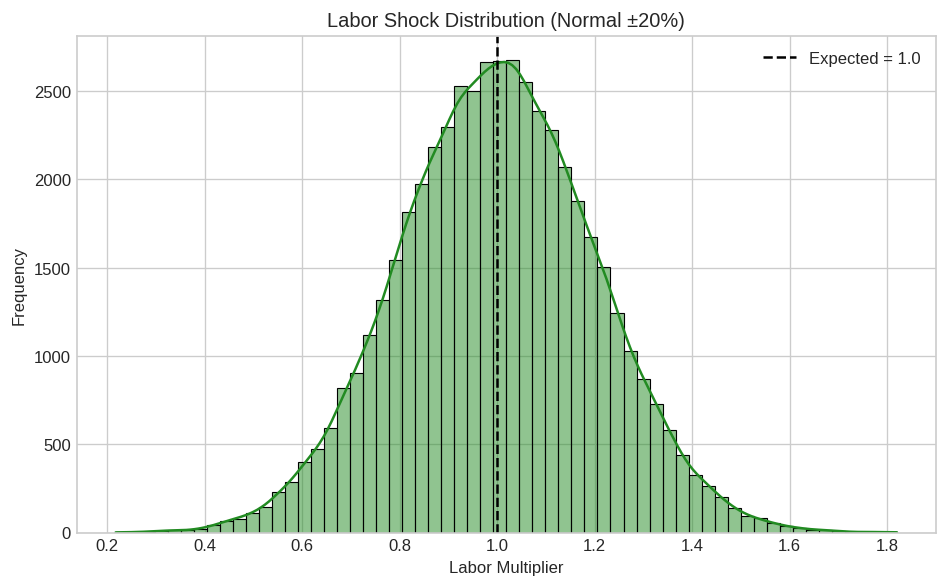

In [6]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-v0_8-whitegrid")

# SAME distribution used in your simulation
labor_mult = np.random.normal(1.0, 0.20, size=50000)

plt.figure(figsize=(8,5))
sns.histplot(labor_mult, bins=60, kde=True, color="forestgreen")
plt.axvline(1.0, color="black", linestyle="--", label="Expected = 1.0")

plt.title("Labor Shock Distribution (Normal ±20%)")
plt.xlabel("Labor Multiplier")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


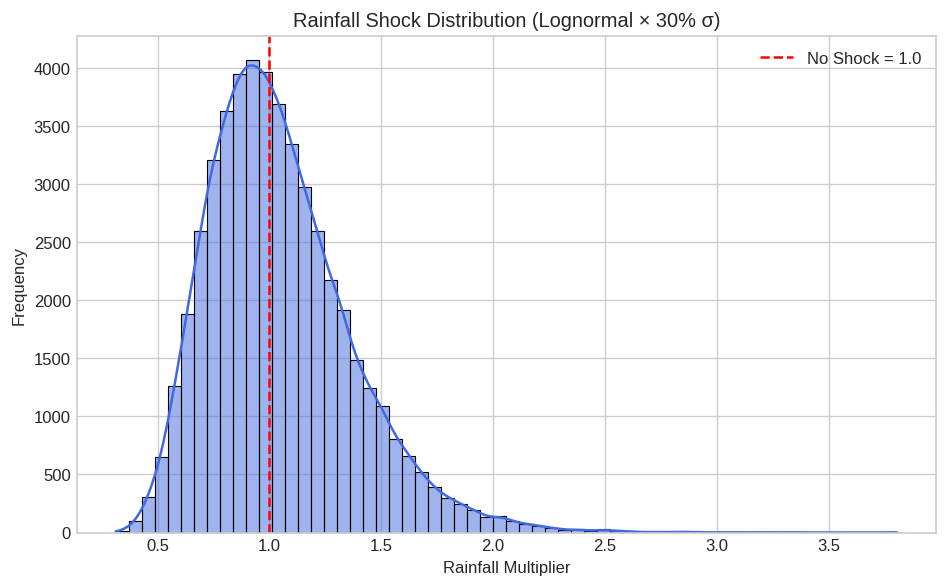

In [7]:
# %%
plt.style.use("seaborn-v0_8-whitegrid")

rain_mult = np.random.lognormal(mean=0, sigma=0.30, size=50000)

plt.figure(figsize=(8,5))
sns.histplot(rain_mult, bins=60, kde=True, color="royalblue")
plt.axvline(1.0, color="red", linestyle="--", label="No Shock = 1.0")

plt.title("Rainfall Shock Distribution (Lognormal × 30% σ)")
plt.xlabel("Rainfall Multiplier")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


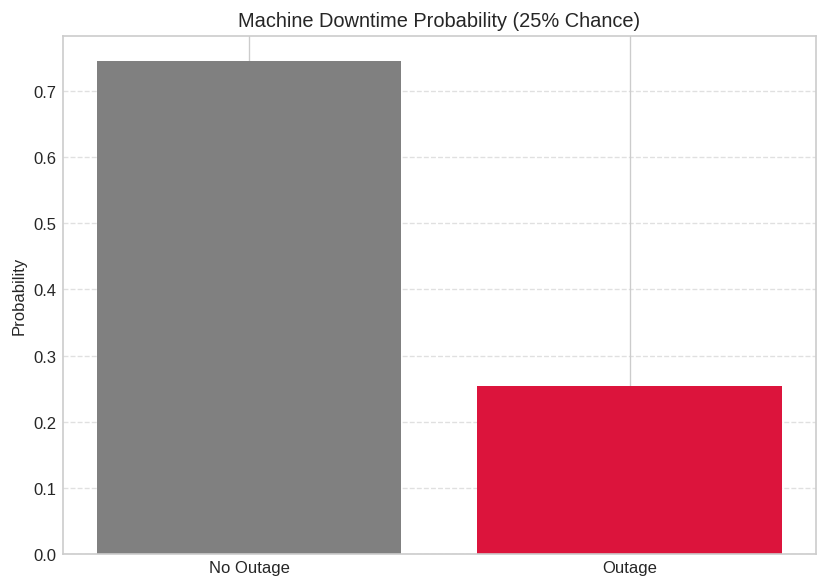

In [8]:
# %%
plt.style.use("seaborn-v0_8-whitegrid")

downtime_events = np.random.binomial(n=1, p=0.25, size=5000)

plt.figure(figsize=(7,5))
plt.bar(["No Outage", "Outage"], 
        [1 - downtime_events.mean(), downtime_events.mean()],
        color=["gray", "crimson"])

plt.title("Machine Downtime Probability (25% Chance)")
plt.ylabel("Probability")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


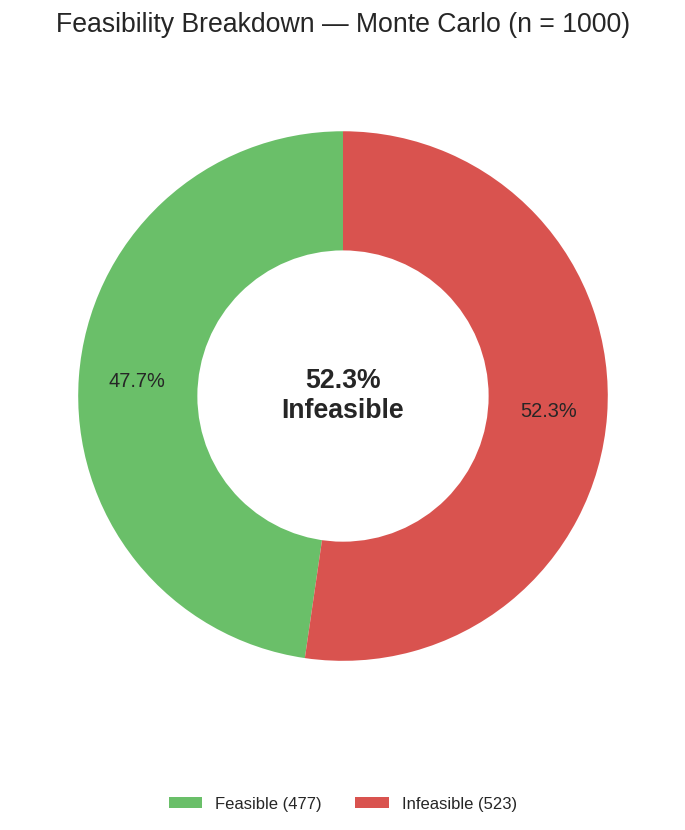

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# Load results
df = pd.read_csv("../../data/processed/monte_carlo_results_v5.csv")

total = len(df)
feasible = (df["status"] == "OK").sum()
infeasible = total - feasible

sizes = [feasible, infeasible]
labels = ["Feasible", "Infeasible (incl. errors)"]
colors = ["#6ABF69", "#D9534F"]  # softer & professional

plt.figure(figsize=(7,7))

# Donut chart
wedges, texts, autotexts = plt.pie(
    sizes,
    autopct='%1.1f%%',
    pctdistance=0.78,
    startangle=90,
    colors=colors,
    textprops={'fontsize': 12}
)

# Add center text
plt.text(0, 0, f"{(infeasible/total)*100:.1f}%\nInfeasible",
         ha='center', va='center', fontsize=16, fontweight='bold')

# Donut hole
centre_circle = plt.Circle((0,0), 0.55, fc='white')
plt.gca().add_artist(centre_circle)

# Legend
plt.legend(
    wedges,
    [f"Feasible ({feasible})", f"Infeasible ({infeasible})"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=2,
    frameon=False
)

plt.title("Feasibility Breakdown — Monte Carlo (n = 1000)", fontsize=16, pad=20)
plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_late_harvest_heatmap_v5(results_path: str):
    """
    Heatmap/barplot showing how often each 'late_harvests' count occurs
    across successful MILP v5 Monte Carlo simulations.
    """

    # Load results
    df = pd.read_csv(results_path)

    # Filter only feasible runs
    df_ok = df[df["status"] == "OK"]

    if "late_harvests" not in df_ok.columns:
        raise ValueError("late_harvests column missing from results file.")

    # Count occurrences of each late_harvests value
    late_counts = df_ok["late_harvests"].value_counts().sort_index()

    late_df = late_counts.reset_index()
    late_df.columns = ["late_harvests", "count"]

    # Plot
    plt.figure(figsize=(12, 5))
    sns.barplot(
        data=late_df,
        x="late_harvests",
        y="count",
        palette="viridis"
    )

    plt.title("Late Harvest Frequency Across Monte Carlo (v5)", fontsize=15)
    plt.xlabel("Number of Late Fields", fontsize=13)
    plt.ylabel("Frequency", fontsize=13)

    for i, row in late_df.iterrows():
        plt.text(i, row["count"] + max(late_df["count"])*0.01,
                 f"{row['count']}", ha="center", fontsize=10)

    plt.tight_layout()
    plt.show()

    return late_df


/tmp/ipykernel_13167/3081433266.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


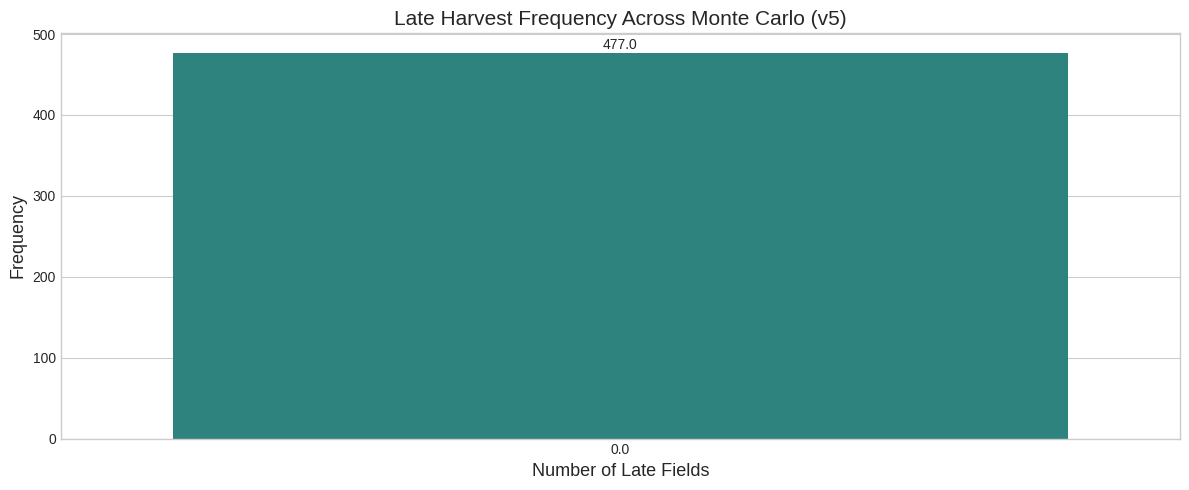

,late_harvests,count
0,0.0,477


In [6]:
plot_late_harvest_heatmap_v5("../../data/processed/monte_carlo_results_v5.csv")

Found 1000 simulation-weekly files (v5).


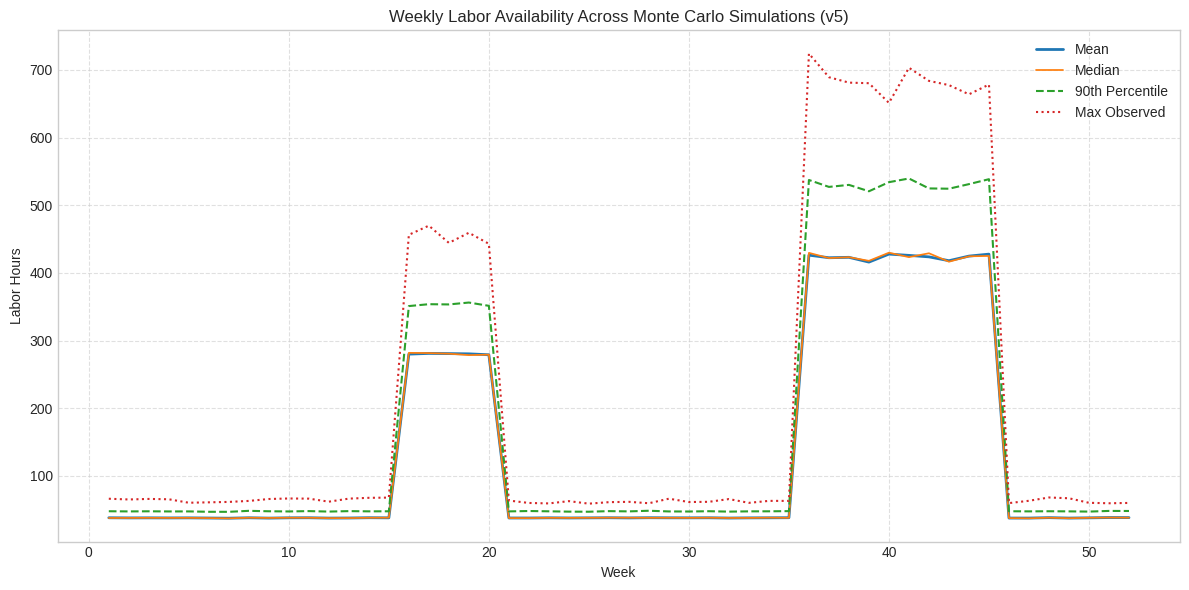

,mean_labor,median_labor,std_labor,p90_labor,max_labor
week,,,,,
1,38.285035,37.981814,7.642081,47.930777,66.400324
2,38.096217,38.056027,7.579798,47.676783,65.330263
3,38.163493,38.180383,7.648739,47.862356,66.123671
4,38.068028,38.101027,7.345504,47.641212,65.623574
5,38.162239,38.154374,7.473829,47.692132,60.495516


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# ============================================
# 1. Load all weekly simulation files (v5)
# ============================================

sim_files = sorted(glob.glob("../../data/processed/mc_v5/weekly_sim_*.csv"))

print(f"Found {len(sim_files)} simulation-weekly files (v5).")

# ============================================
# 2. Aggregate labor by week
# ============================================

weekly_labor = {}

for file in sim_files:
    df = pd.read_csv(file)

    # Keep only target year
    df = df[df["year"] == 2017]

    # Aggregate
    for _, row in df.iterrows():
        w = int(row["week"])
        labor_val = float(row["labor_hours"])

        weekly_labor.setdefault(w, []).append(labor_val)

# ============================================
# 3. Convert to DataFrame
# ============================================

weeks_sorted = sorted(weekly_labor.keys())

labor_df = pd.DataFrame({
    "week": weeks_sorted,
    "mean_labor":   [np.mean(weekly_labor[w]) for w in weeks_sorted],
    "median_labor": [np.median(weekly_labor[w]) for w in weeks_sorted],
    "std_labor":    [np.std(weekly_labor[w]) for w in weeks_sorted],
    "p90_labor":    [np.percentile(weekly_labor[w], 90) for w in weeks_sorted],
    "max_labor":    [np.max(weekly_labor[w]) for w in weeks_sorted],
})

labor_df = labor_df.set_index("week")

# ============================================
# 4. Plot – Weekly Labor Pressure Across MC Runs
# ============================================

plt.figure(figsize=(12, 6))
plt.plot(labor_df["mean_labor"],   label="Mean",  linewidth=2)
plt.plot(labor_df["median_labor"], label="Median", linewidth=1.25)
plt.plot(labor_df["p90_labor"],    label="90th Percentile", linestyle="--")
plt.plot(labor_df["max_labor"],    label="Max Observed", linestyle=":")

plt.title("Weekly Labor Availability Across Monte Carlo Simulations (v5)")
plt.xlabel("Week")
plt.ylabel("Labor Hours")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

labor_df.head()


Valid simulations: 477 / 1000


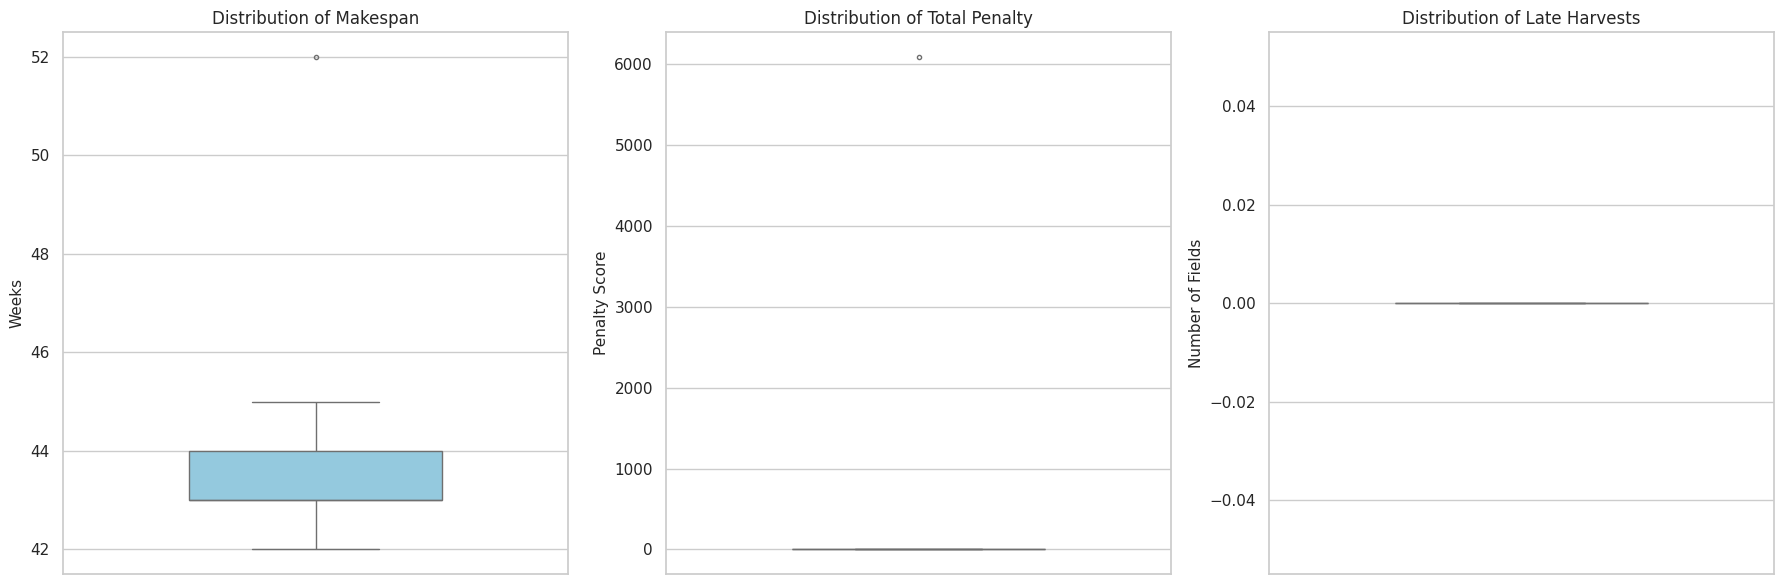

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------
# 1. Clean only successful simulations
# -------------------------------------
clean_results = results_df[
    (results_df["status"] == "OK") &
    results_df[["makespan", "total_penalty", "late_harvests"]].notna().all(axis=1)
]

print(f"Valid simulations: {len(clean_results)} / {len(results_df)}")

# -------------------------------------
# 2. Plot layout
# -------------------------------------
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------------------------------------------------------
# Plot 1: Makespan
# ---------------------------------------------------------
sns.boxplot(
    data=clean_results,
    y="makespan",
    ax=axes[0],
    color="skyblue",
    width=0.5,
    fliersize=3
)
axes[0].set_title("Distribution of Makespan", fontsize=12)
axes[0].set_ylabel("Weeks", fontsize=11)
axes[0].set_xlabel("")

# ---------------------------------------------------------
# Plot 2: Total Penalty
# ---------------------------------------------------------
sns.boxplot(
    data=clean_results,
    y="total_penalty",
    ax=axes[1],
    color="lightcoral",
    width=0.5,
    fliersize=3
)
axes[1].set_title("Distribution of Total Penalty", fontsize=12)
axes[1].set_ylabel("Penalty Score", fontsize=11)
axes[1].set_xlabel("")

# ---------------------------------------------------------
# Plot 3: Late Harvests
# ---------------------------------------------------------
sns.boxplot(
    data=clean_results,
    y="late_harvests",
    ax=axes[2],
    color="lightgreen",
    width=0.5,
    fliersize=3
)
axes[2].set_title("Distribution of Late Harvests", fontsize=12)
axes[2].set_ylabel("Number of Fields", fontsize=11)
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()


Valid simulations: 477 / 1000


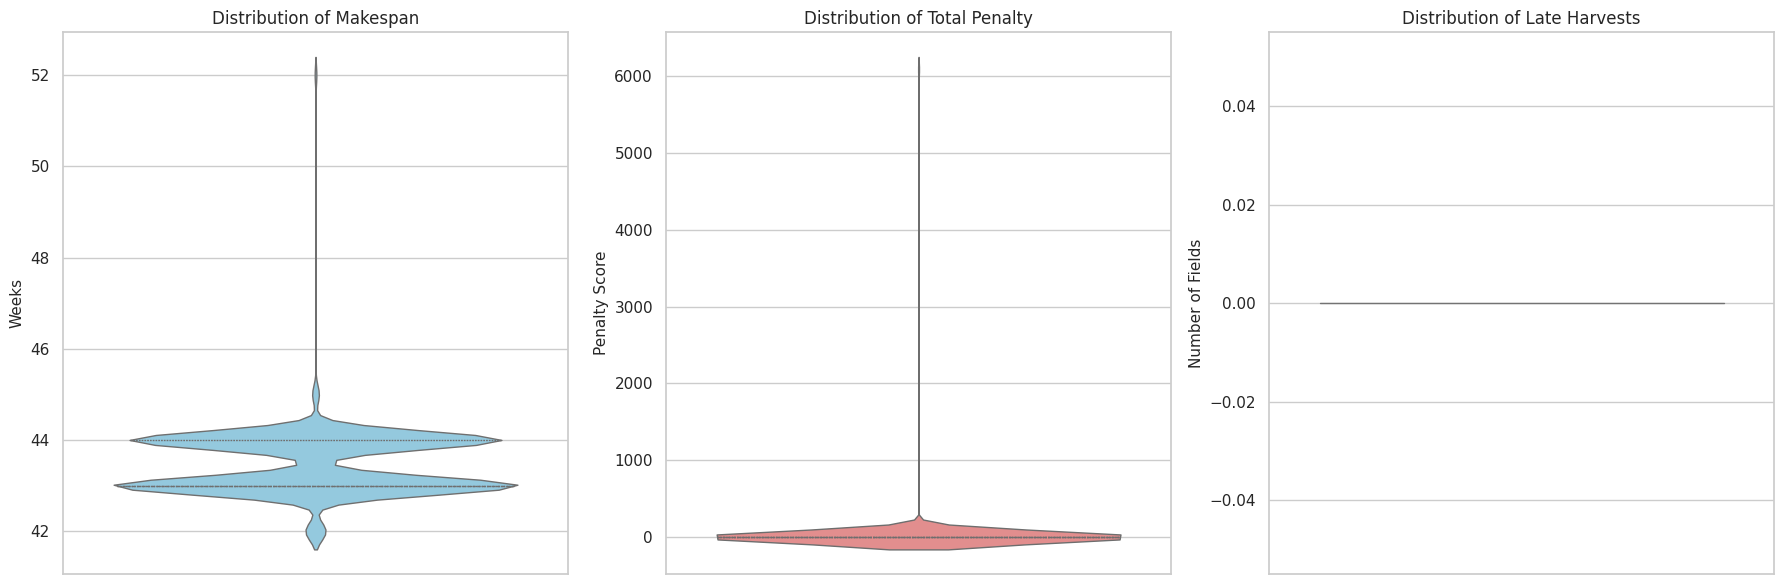

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# ---------------------------------------------------------
# 1. KEEP ONLY CLEAN, SUCCESSFUL SIMULATIONS
# ---------------------------------------------------------
clean_results = results_df[
    (results_df["status"] == "OK") &
    results_df[["makespan", "total_penalty", "late_harvests"]].notna().all(axis=1)
]

print(f"Valid simulations: {len(clean_results)} / {len(results_df)}")

# ---------------------------------------------------------
# 2. VIOLIN PLOTS
# ---------------------------------------------------------
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# ---------------------------------------------------------
# Plot 1: Makespan
# ---------------------------------------------------------
sns.violinplot(
    data=clean_results,
    y="makespan",
    ax=axes[0],
    color="skyblue",
    linewidth=1,
    inner="quartile"
)
axes[0].set_title("Distribution of Makespan", fontsize=12)
axes[0].set_ylabel("Weeks", fontsize=11)
axes[0].set_xlabel("")

# ---------------------------------------------------------
# Plot 2: Total Penalty
# ---------------------------------------------------------
sns.violinplot(
    data=clean_results,
    y="total_penalty",
    ax=axes[1],
    color="lightcoral",
    linewidth=1,
    inner="quartile"
)
axes[1].set_title("Distribution of Total Penalty", fontsize=12)
axes[1].set_ylabel("Penalty Score", fontsize=11)
axes[1].set_xlabel("")

# ---------------------------------------------------------
# Plot 3: Late Harvests
# ---------------------------------------------------------
sns.violinplot(
    data=clean_results,
    y="late_harvests",
    ax=axes[2],
    color="lightgreen",
    linewidth=1,
    inner="quartile"
)
axes[2].set_title("Distribution of Late Harvests", fontsize=12)
axes[2].set_ylabel("Number of Fields", fontsize=11)
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()
